## Testing integration

### Reasoning Agent

In [3]:
from backend.workflow.graph import graph
# from langchain.agents import AgentState

# reasoning_state = AgentState({
#     "prompt": "Create a scene that visually approximates the value of Pi (π) by \
#     calculating the area of a unit circle (A=πr2, with r=1, so A=π) using \
#     the Monte Carlo method"
# })

state = graph.nodes["reasoning_agent"].invoke(input={
    "prompt": "Create a scene that visually approximates the value of Pi (π) by \
    calculating the area of a unit circle (A=πr2, with r=1, so A=π) using \
    the Monte Carlo method"
})
for step in state["steps"]:
    print(step.description)

Initialize the scene by setting up a square canvas that will contain a unit circle centered at the origin. Define the square boundaries from (-1,-1) to (1,1) to match the unit circle radius.
Create a static unit circle object centered at the origin with radius 1. Render it as a light gray outline to serve as the reference area.
Overlay a grid or background shading for the square to visually separate inside vs. outside the circle. Optionally use a subtle light blue fill for the square area.
Introduce a counter display at the top or bottom of the screen to show the current estimate of π. This will be a Text or DecimalNumber that updates dynamically.
Generate a set of random points within the square. For each point, decide whether it lies inside the circle (distance from origin <= 1). Represent each point as a small dot or tiny circle.
Animate the points being plotted one by one (or in small batches) to build up the Monte Carlo simulation. Use a fade-in or grow animation for each dot.
Col

In [ ]:
# TODO: create a node that selects the first query after query decomposer

### Query Decomposer

In [1]:
current_step_description = "Initialize the scene by setting up a square canvas that will contain a unit\
    circle centered at the origin. Define the square boundaries from (-1,-1) to (1,1) \
    to match the unit circle radius."

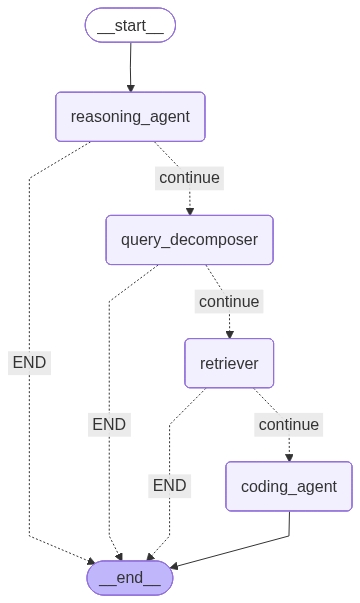

Code prompt: Create a square canvas with bounds from (-1,-1) to (1,1) and draw a unit circle centered at the origin.
Documentation prompt: Explain how to set up a square canvas that encloses a unit circle, including boundary definitions and coordinate system.
Summary prompt: Define a square canvas (bounds: -1 to 1) containing a unit circle centered at (0,0).


In [2]:
from backend.workflow.graph import graph

state = graph.nodes["query_decomposer"].invoke(input={
    "query": current_step_description
})

print("Code prompt:", state["prompts"].code_prompt)
print("Documentation prompt:", state["prompts"].documentation_prompt)
print("Summary prompt:", state["prompts"].summary_prompt)


### Testing Retriever

In [3]:
query_decomposer_op = state["prompts"]

In [4]:
from backend.workflow.graph import graph
import nest_asyncio
nest_asyncio.apply()

state = await graph.nodes["retriever"].ainvoke(input={
    "prompts": query_decomposer_op
})

print(state["formatted_docs"])

===============Block 1===============
Relevance Score: 0.6288315807380355

#!/usr/bin/env python


from manim import *

# To watch one of these scenes, run the following:
# python --quality m manim -p example_scenes.py SquareToCircle
#
# Use the flag --quality l for a faster rendering at a lower quality.
# Use -s to skip to the end and just save the final frame
# Use the -p to have preview of the animation (or image, if -s was
# used) pop up once done.
# Use -n <number> to skip ahead to the nth animation of a scene.
# Use -r <number> to specify a resolution (for example, -r 1920,1080
# for a 1920x1080 video)

Metadata:
source: /home/msvelan/Programming/third-party/manim/example_scenes/basic.py
filename: basic.py
type: code
===============Block 2===============
Relevance Score: 0.6218436280209453

References:
  :ref_classes: MathTex Circle Dot Line VGroup
  :ref_methods: Mobject.add_updater Mobject.remove_updater
  :ref_functions: always_redraw
Code:
class SineCurveUnitCircle(Scene):
  

### Testing Coding Agent

In [5]:
formatted_docs = state["formatted_docs"]

In [1]:
formatted_docs = """
===============Block 1===============
Relevance Score: 0.6288315807380355

#!/usr/bin/env python


from manim import *

# To watch one of these scenes, run the following:
# python --quality m manim -p example_scenes.py SquareToCircle
#
# Use the flag --quality l for a faster rendering at a lower quality.
# Use -s to skip to the end and just save the final frame
# Use the -p to have preview of the animation (or image, if -s was
# used) pop up once done.
# Use -n <number> to skip ahead to the nth animation of a scene.
# Use -r <number> to specify a resolution (for example, -r 1920,1080
# for a 1920x1080 video)

Metadata:
source: /home/msvelan/Programming/third-party/manim/example_scenes/basic.py
filename: basic.py
type: code
===============Block 2===============
Relevance Score: 0.6218436280209453

References:
  :ref_classes: MathTex Circle Dot Line VGroup
  :ref_methods: Mobject.add_updater Mobject.remove_updater
  :ref_functions: always_redraw
Code:
class SineCurveUnitCircle(Scene):
    # contributed by heejin_park, https://infograph.tistory.com/230
    def construct(self):
        self.show_axis()
        self.show_circle()
        self.move_dot_and_draw_curve()
        self.wait()

    def show_axis(self):
        x_start = np.array([-6,0,0])
        x_end = np.array([6,0,0])

        y_start = np.array([-4,-2,0])
        y_end = np.array([-4,2,0])

        x_axis = Line(x_start, x_end)
        y_axis = Line(y_start, y_end)

        self.add(x_axis, y_axis)
        self.add_x_labels()

        self.origin_point = np.array([-4,0,0])
        self.curve_start = np.array([-3,0,0])

    def add_x_labels(self):
        x_labels = [
            MathTex(r"\pi"), MathTex(r"2 \pi"),
            MathTex(r"3 \pi"), MathTex(r"4 \pi"),
        ]

        for i in range(len(x_labels)):
            x_labels[i].next_to(np.array([-1 + 2*i, 0, 0]), DOWN)
            self.add(x_labels[i])

    def show_circle(self):
        circle = Circle(radius=1)
        circle.move_to(self.origin_point)
        self.add(circle)
        self.circle = circle

    def move_dot_and_draw_curve(self):
        orbit = self.circle
        origin_point = self.origin_point

        dot = Dot(radius=0.08, color=YELLOW)
        dot.move_to(orbit.point_from_proportion(0))
        self.t_offset = 0
        rate = 0.25

        def go_around_circle(mob, dt):
            self.t_offset += (dt * rate)
            # print(self.t_offset)
            mob.move_to(orbit.point_from_proportion(self.t_offset % 1))

        def get_line_to_circle():
            return Line(origin_point, dot.get_center(), color=BLUE)

        def get_line_to_curve():
            x = self.curve_start[0] + self.t_offset * 4
            y = dot.get_center()[1]
            return Line(dot.get_center(), np.array([x,y,0]), color=YELLOW_A, stroke_width=2 )


        self.curve = VGroup()
        self.curve.add(Line(self.curve_start,self.curve_start))
        def get_curve():
            last_line = self.curve[-1]
            x = self.curve_start[0] + self.t_offset * 4
            y = dot.get_center()[1]
            new_line = Line(last_line.get_end(),np.array([x,y,0]), color=YELLOW_D)
            self.curve.add(new_line)

            return self.curve

        dot.add_updater(go_around_circle)

        origin_to_circle_line = always_redraw(get_line_to_circle)
        dot_to_curve_line = always_redraw(get_line_to_curve)
        sine_curve_line = always_redraw(get_curve)

        self.add(dot)
        self.add(orbit, origin_to_circle_line, dot_to_curve_line, sine_curve_line)
        self.wait(8.5)

        dot.remove_updater(go_around_circle)

Metadata:
source: /home/msvelan/Programming/third-party/manim/docs/source/examples.rst
filename: examples.rst
type: code
ref_classes: 
ref_functions: 
ref_methods: 
===============Block 3===============
Relevance Score: 0.6117303273195711

class OpeningManim(Scene):
    def construct(self):
        title = Tex(r"This is some \LaTeX")
        basel = MathTex(r"\sum_{n=1}^\infty \frac{1}{n^2} = \frac{\pi^2}{6}")
        VGroup(title, basel).arrange(DOWN)
        self.play(
            Write(title),
            FadeIn(basel, shift=DOWN),
        )
        self.wait()

        transform_title = Tex("That was a transform")
        transform_title.to_corner(UP + LEFT)
        self.play(
            Transform(title, transform_title),
            LaggedStart(*(FadeOut(obj, shift=DOWN) for obj in basel)),
        )
        self.wait()

        grid = NumberPlane()
        grid_title = Tex("This is a grid", font_size=72)
        grid_title.move_to(transform_title)

        self.add(grid, grid_title)  # Make sure title is on top of grid
        self.play(
            FadeOut(title),
            FadeIn(grid_title, shift=UP),
            Create(grid, run_time=3, lag_ratio=0.1),
        )
        self.wait()

        grid_transform_title = Tex(
            r"That was a non-linear function \\ applied to the grid",
        )
        grid_transform_title.move_to(grid_title, UL)
        grid.prepare_for_nonlinear_transform()
        self.play(
            grid.animate.apply_function(
                lambda p: p
                + np.array(
                    [
                        np.sin(p[1]),
                        np.sin(p[0]),
                        0,
                    ],
                ),
            ),
            run_time=3,
        )
        self.wait()
        self.play(Transform(grid_title, grid_transform_title))
        self.wait()


class SquareToCircle(Scene):
    def construct(self):
        circle = Circle()
        square = Square()
        square.flip(RIGHT)
        square.rotate(-3 * TAU / 8)
        circle.set_fill(PINK, opacity=0.5)

        self.play(Create(square))
        self.play(Transform(square, circle))
        self.play(FadeOut(square))

Metadata:
source: /home/msvelan/Programming/third-party/manim/example_scenes/basic.py
filename: basic.py
type: code
===============Block 4===============
Relevance Score: 0.5118552432232841

Title: Quickstart > Transforming a square into a circle
With our circle animation complete, let's move on to something a little more complicated.
Open scene.py, and add the following code snippet below the CreateCircle class:
class SquareToCircle(Scene):
    def construct(self):
        circle = Circle()  # create a circle
        circle.set_fill(PINK, opacity=0.5)  # set color and transparency

        square = Square()  # create a square
        square.rotate(PI / 4)  # rotate a certain amount

        self.play(Create(square))  # animate the creation of the square
        self.play(Transform(square, circle))  # interpolate the square into the circle
        self.play(FadeOut(square))  # fade out animation
Render SquareToCircle by running the following command in the command line:
The following animation will render:
This example shows one of the primary features of Manim: the ability to implement complicated and mathematically intensive animations (such as cleanly interpolating between two geometric shapes) with just a few lines of code.

Metadata:
source: /home/msvelan/Programming/third-party/manim/docs/source/tutorials/quickstart.rst
filename: quickstart.rst
type: documentation
title: Quickstart
===============Block 5===============
Relevance Score: 0.4509830176830292

Title: A deep dive into Manim's internals > Mobject Initialization > Squares and Circles: back to our Toy Example
With a basic understanding of different types of mobjects, and an idea of how vectorized mobjects are built we can now come back to our toy example and the execution of the .Scene.construct method. In the first two lines of our animation script, the orange_square and the blue_circle are initialized.
When creating the orange square by running
the initialization method of .Square, Square.__init__, is called. Looking at the implementation, we can see that the side_length attribute of the square is set, and then
is called. This super call is the Python way of calling the initialization function of the parent class. As .Square inherits from .Rectangle, the next method called is Rectangle.__init__. There, only the first three lines are really relevant for us:
First, the initialization function of the parent class of .Rectangle -- .Polygon -- is called. The four positional arguments passed are the four corners of the polygon: UR is up right (and equal to UP + RIGHT), UL is up left (and equal to UP + LEFT), and so forth. Before we follow our debugger deeper, let us observe what happens with the constructed polygon: the remaining two lines stretch the polygon to fit the specified width and height such that a rectangle with the desired measurements is created.
The initialization function of .Polygon is particularly simple, it only calls the initialization function of its parent class, .Polygram. There, we have almost reached the end of the chain: .Polygram inherits from .VMobject, whose initialization function mainly sets the values of some attributes (quite similar to Mobject.__init__, but more specific to the Bézier curves that make up the mobject).
After calling the initialization function of .VMobject, the constructor of .Polygram also does something somewhat odd: it sets the points (which, you might remember above, should actually be set in a corresponding generate_points method of .Polygram).
In several instances, the implementation of mobjects does not really stick to all aspects of Manim's interface. This is unfortunate, and increasing consistency is something that we actively work on. Help is welcome!
Without going too much into detail, .Polygram sets its points attribute via .VMobject.start_new_path, .VMobject.add_points_as_corners, which take care of setting the quadruples of anchors and handles appropriately. After the points are set, Python continues to process the call stack until it reaches the method that was first called; the initialization method of .Square. After this, the square is initialized and assigned to the orange_square variable.
The initialization of blue_circle is similar to the one of orange_square, with the main difference being that the inheritance chain of .Circle is different. Let us briefly follow the trace of the debugger:
The implementation of .Circle.__init__ immediately calls the initialization method of .Arc, as a circle in Manim is simply an arc with an angle of τ = 2π. When initializing the arc, some basic attributes are set (like Arc.radius, Arc.arc_center, Arc.start_angle, and Arc.angle), and then the initialization method of its parent class, .TipableVMobject, is called (which is a rather abstract base class for mobjects which a arrow tip can be attached to). Note that in contrast to .Polygram, this class does not preemptively generate the points of the circle.
After that, things are less exciting: .TipableVMobject again sets some attributes relevant for adding arrow tips, and afterwards passes to the initialization method of .VMobject. From there, .Mobject is initialized and .Mobject.generate_points is called, which actually runs the method implemented in .Arc.generate_points.
After both our orange_square and the blue_circle are initialized, the square is actually added to the scene. The .Scene.add method is actually doing a few interesting things, so it is worth to dig a bit deeper in the next section.

Metadata:
source: /home/msvelan/Programming/third-party/manim/docs/source/guides/deep_dive.rst
filename: deep_dive.rst
type: documentation
title: A deep dive into Manim's internals
===============Block 6===============
Relevance Score: 0.4367174245883577

manim.mobject.frame
manim.mobject.geometry.arc
manim.mobject.geometry.boolean_ops
manim.mobject.geometry.line
manim.mobject.geometry.polygram
manim.mobject.geometry.shape_matchers
manim.mobject.geometry.tips
manim.mobject.graph
manim.mobject.graphing.coordinate_systems
manim.mobject.graphing.functions
manim.mobject.graphing.number_line
manim.mobject.graphing.probability
manim.mobject.graphing.scale
manim.mobject.logo
manim.mobject.matrix
manim.mobject.mobject
manim.mobject.table
manim.mobject.three_d.polyhedra
manim.mobject.three_d.three_d_utils
manim.mobject.three_d.three_dimensions
manim.mobject.svg.brace
manim.mobject.svg.svg_mobject
manim.mobject.text.code_mobject
manim.mobject.text.numbers
manim.mobject.text.tex_mobject
manim.mobject.text.text_mobject
manim.mobject.types.image_mobject
manim.mobject.types.point_cloud_mobject
manim.mobject.types.vectorized_mobject
manim.mobject.value_tracker
manim.mobject.vector_field
:parts: 1
:top-classes: manim.mobject.mobject.Mobject

Metadata:
type: summary
supplement: inheritance-diagram
source: /home/msvelan/Programming/third-party/manim/docs/source/reference.rst
filename: reference.rst
===============Block 7===============
Relevance Score: 0.42294017858382915

manim.camera.camera
manim.camera.mapping_camera
manim.camera.moving_camera
manim.camera.multi_camera
manim.camera.three_d_camera
:parts: 1
:top-classes: manim.camera.camera.Camera, manim.mobject.mobject.Mobject

Metadata:
type: summary
supplement: inheritance-diagram
source: /home/msvelan/Programming/third-party/manim/docs/source/reference.rst
filename: reference.rst
"""

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_294608/1969831208.py:1: SyntaxWarning: invalid escape sequence '\p'
  formatted_docs = """


In [2]:
current_step_description = "Initialize the scene by setting up a square canvas that will contain a unit\
    circle centered at the origin. Define the square boundaries from (-1,-1) to (1,1) \
    to match the unit circle radius."

In [3]:
# coding_agent_input = {
#     "current_step_description": current_step_description,
#     "code_generated": "",
#     "formatted_docs": formatted_docs,
#     "feedback": "",
# }

from backend.workflow.graph import graph

state = graph.nodes["coding_agent"].invoke(input={
    "current_step_description": current_step_description,
    "code_generated": "",
    "formatted_docs": formatted_docs,
    "feedback": "",
})

# print(state["code_generated"])

[values] {'messages': [HumanMessage(content='\nQuery: Initialize the scene by setting up a square canvas that will contain a unit    circle centered at the origin. Define the square boundaries from (-1,-1) to (1,1)     to match the unit circle radius.\nCode generated so far:\n\nContext from manim-ce documentation:\n\n===============Block 1===============\nRelevance Score: 0.6288315807380355\n\n#!/usr/bin/env python\n\n\nfrom manim import *\n\n# To watch one of these scenes, run the following:\n# python --quality m manim -p example_scenes.py SquareToCircle\n#\n# Use the flag --quality l for a faster rendering at a lower quality.\n# Use -s to skip to the end and just save the final frame\n# Use the -p to have preview of the animation (or image, if -s was\n# used) pop up once done.\n# Use -n <number> to skip ahead to the nth animation of a scene.\n# Use -r <number> to specify a resolution (for example, -r 1920,1080\n# for a 1920x1080 video)\n\nMetadata:\nsource: /home/msvelan/Programming/

In [4]:
print(state)

{'code_generated': {'messages': [HumanMessage(content='\nQuery: Initialize the scene by setting up a square canvas that will contain a unit    circle centered at the origin. Define the square boundaries from (-1,-1) to (1,1)     to match the unit circle radius.\nCode generated so far:\n\nContext from manim-ce documentation:\n\n===============Block 1===============\nRelevance Score: 0.6288315807380355\n\n#!/usr/bin/env python\n\n\nfrom manim import *\n\n# To watch one of these scenes, run the following:\n# python --quality m manim -p example_scenes.py SquareToCircle\n#\n# Use the flag --quality l for a faster rendering at a lower quality.\n# Use -s to skip to the end and just save the final frame\n# Use the -p to have preview of the animation (or image, if -s was\n# used) pop up once done.\n# Use -n <number> to skip ahead to the nth animation of a scene.\n# Use -r <number> to specify a resolution (for example, -r 1920,1080\n# for a 1920x1080 video)\n\nMetadata:\nsource: /home/msvelan/Pr

In [8]:
print(state["code_generated"]["messages"][-2].content)

from manim import *

class Enginimate(Scene):
    def construct(self):
        square = Square(side_length=2, color=WHITE)
        circle = Circle(radius=1, color=YELLOW)
        self.add(square, circle)


### Overall testing with graph invoke

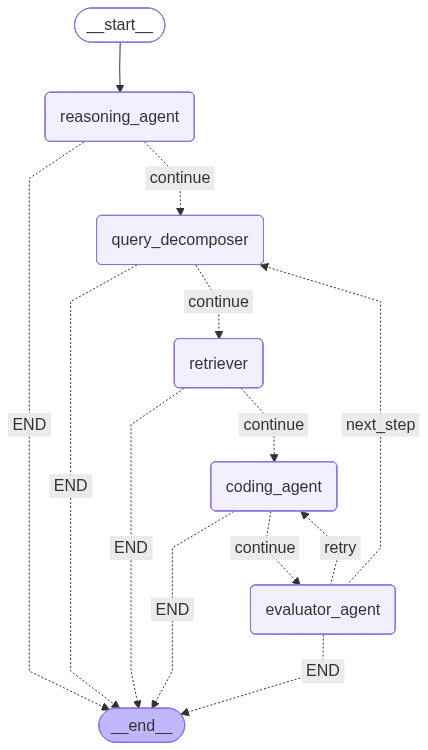

Reasoning Agent: 
[VideoCreationStep(step_id=1, description='Set up the scene canvas and define the coordinate system. Create a unit circle centered at the origin with radius 1. Draw the circle outline and label its radius.'), VideoCreationStep(step_id=2, description='Create a bounding square that circumscribes the unit circle (side length 2). Draw the square outline and label its sides.'), VideoCreationStep(step_id=3, description='Generate a large number of random points (e.g., 500–1000) within the square. Represent each point as a small dot or dot with a subtle color.'), VideoCreationStep(step_id=4, description='Iterate through each random point: if it lies inside the circle, color it green; if outside, color it red. Use a short fade-in animation for each point to reveal the distribution gradually.'), VideoCreationStep(step_id=5, description='After all points are plotted, count the number of points inside the circle (N_inside) and outside (N_outside). Compute the ratio N_inside/(N_in

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
from backend.workflow.graph import graph
import nest_asyncio
nest_asyncio.apply()

state = await graph.ainvoke({
    "query": "Create a scene that visually approximates the value of Pi (π) by \
calculating the area of a unit circle (A=πr2, with r=1, so A=π) using \
the Monte Carlo method"
}, config={
    "recursion_limit": 100
})

In [ ]:
# I guess the entire stuff is more or less working
from backend.workflow.graph import graph
import nest_asyncio
nest_asyncio.apply()

state = await graph.ainvoke({
    "query": "Create a scene that visually approximates the value of Pi (π) by \
calculating the area of a unit circle (A=πr2, with r=1, so A=π) using \
the Monte Carlo method"
}, config={
    "recursion_limit": 100
})

In [1]:
import operator
import os
from typing import Annotated
from uuid import uuid4

from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from pydantic import BaseModel, Field

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_KEY")
# os.environ["LANGSMITH_ENDPOINT"] = os.getenv("LANGSMITH_ENDPOINT",
#                                              "https://api.smith.langchain.com")
# os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_KEY")
# os.environ["LANGSMITH_TRACING"] = "true"
# os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT", "Enginimate")

## Create Reasoning Agent

In [ ]:
from typing import Literal


class VideoCreationStep(BaseModel):
    step_id: int = Field(default=0, description="nth step in the sequential \
        order for scene creation")
    description: str = Field(default="", description="Description of the current step")

class ReasoningAgentOutput(BaseModel):
    steps: list[VideoCreationStep] = Field(default_factory=list, description="Steps \
        required for the scene creation")

class QueryDecomposerOutput(BaseModel):
    code_prompt: str = Field(default="", description="Clean minimal prompt \
        for fetching relevant code snippets")
    documentation_prompt: str = Field(default="", description="Clean minimal prompt \
        for fetching relevant documentation")
    summary_prompt: str = Field(default="", description="Clean minimal prompt for \
        fetching relevant autosummary snippets \
        (summary of class names, functions, methods)")

class State(BaseModel):
    uuid: str = Field(default=uuid4().hex, description="Unique identifier for client")
    query: str = Field(default="", description="User query for scene generation")
    steps: list[VideoCreationStep] = Field(default_factory=list, description="List of \
        planned steps for the scene in sequential order")
    current_step_description: str = Field(default="", description="Description of \
        current step for scene creation")
    # Write after code generation of each major step
    completed_steps: int = Field(default=0, description="Total completed steps")
    prompts: QueryDecomposerOutput = Field(default_factory=dict, description="\
        List of prompts for retrieval of relevant documents in the RAG pipeline")
    formatted_docs: str = Field(default="", description="Content of retrieved \
        relevant documents")
    code_generated: str = Field(default="", description="Correct code generated so far \
        until the current step")
    error: str = Field(default="", description="Error generated on code execution")
    feedback: list[str] = Field(default_factory=list, description="List of \
        constructive feedback for improving the current code")
    done_code_generation: Literal["yes", "no"] = Field(default="no", description="\
        Code generation for all steps is done or not")
    url: str = Field(default="", description="Final video url after \
        uploading to cloudinary")
    success: bool = Field(default=True, description="Indicates if the pipeline has \
        completed successfully")
    error_message: str = Field(default="", description="Error message if the \
        pipeline failed")

In [3]:
def reasoning_agent(state: State):
    llm = init_chat_model("groq:openai/gpt-oss-20b", temperature=0.7)

    system_prompt = """You are an expert senior Python developer \
    specializing in the Manim animation library.  
    Your task is to plan out the detailed, step-by-step process \
    required to implement a scene in Manim based on the description provided.

    Requirements:
    1. Break down the scene into clear, actionable steps in sequential \
    order for implementation.
    2. Include what objects, animations, and transitions will be used.
    3. Mention any special camera movements or effects if they enhance visual appeal.
    4. Describe the order of execution logically, from setup to rendering.
    5. Avoid writing actual Manim code — focus only on the planning and structure.
    """

    prompt_template = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", "{scene_description}"),
    ])

    planner = llm.with_structured_output(ReasoningAgentOutput)
    pipeline = prompt_template | planner
    scene_generation_steps= pipeline.invoke({
        "scene_description": state.prompt
    })
    return {
        "steps": scene_generation_steps.steps
    }

In [4]:
def query_decomposer(state: State):
    llm = init_chat_model("groq:openai/gpt-oss-20b", temperature=0.7)

    system_prompt = """You are an expert at RAG systems. Your task is to \
    rewrite a query in a clear consise way so that embedding models can \
    better understand the query and fetch relevant documents for different types.
    """

    prompt_template = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", "{query}"),
    ])

    query_decomposer_llm = llm.with_structured_output(QueryDecomposerOutput)
    pipeline = prompt_template | query_decomposer_llm
    prompts = pipeline.invoke({
        "query": state.query
    })
    return {
        "prompts": prompts
    }

In [5]:
async def retriever(state: State):
    def format_retrieved_docs(docs):
        content = ""
        for i, (doc, score) in enumerate(docs, 1):
            content += "="*30 + f"Block {i}" + "="*30 + "\n"
            content += f"Relevance Score: {score}\n\n"
            content += doc.page_content + "\n"
            content += "\nMetadata:\n"
            for k, v in doc.metadata.items():
                content += f"{k}: {v}\n"
        return content
    
    from backend.workflow.utils.retrieve import retrieve_docs
    docs = await retrieve_docs(state.query, k_summary=1)
    return {
        "formatted_docs": format_retrieved_docs(docs)
    }

In [9]:
# route on error
def route_on_error(state: State):
    if len(state["error_message"])!=0:
        return "END"
    return "continue"

In [7]:
from pydantic import BaseModel, Field


# Define the desired structure for the code output
class PythonCode(BaseModel):
    """
    A structure to hold only the generated Python code.
    The LLM MUST only output the code within this structure.
    """
    code: str = Field(
        description="The complete, runnable Python code as a single string. \
        MUST NOT include any surrounding text, explanations, or conversational filler."
    )

def coding_agent(state: State):

    from langchain.agents import create_agent
    from langchain.agents.middleware import (
        ModelCallLimitMiddleware,
        SummarizationMiddleware,
    )
    from langchain_core.prompts import ChatPromptTemplate
    from langgraph.checkpoint.memory import InMemorySaver

    model = init_chat_model("groq:openai/gpt-oss-120b")
    # TODO: implement docker sandbox executor tool, use @after_model hook to run the tool
    # TODO: add tools like fetch_code_snippets, fetch_docs, fetch_summary as tool
    system_prompt="""
You are a specialized code generation engine. Your SOLE function is to generate \
the requested Python code. You MUST strictly adhere to the provided output schema \
and DO NOT include any conversational text, reasoning, or additional explanations \
outside of the code field. The output must be valid JSON matching the PythonCode schema.
    """
    agent = create_agent(
        model,
        system_prompt=system_prompt,
        response_format=PythonCode,
        middleware=[
            SummarizationMiddleware(
                model="groq:llama-3.1-8b-instant",
                max_tokens_before_summary=4000,
                messages_to_keep=20,
            ),
            ModelCallLimitMiddleware(
                thread_limit=10,  # Max 10 calls per thread (across runs)
                run_limit=5,  # Max 5 calls per run (single invocation)
                exit_behavior="end",  # Or "error" to raise exception
            ),
            # NOTE: add custom middleware for docker execution here
        ],
        checkpointer=InMemorySaver()
    )

    query = """
Query: {current_step_description}
Code generated so far:
{code_generated}
Context from manim-ce documentation:
{formatted_docs}
Feedback:
{feedback}
    """

    template = ChatPromptTemplate.from_messages([
        ("human", query)
    ])

    pipeline = template | agent
    result = pipeline.invoke({
        "current_step_description": state.current_step_description,
        "code_generated": state.code_generated,
        "formatted_docs": state.formatted_docs,
        "feedback": state.feedback
    })

    return {
        "code_generated": result.code
    }

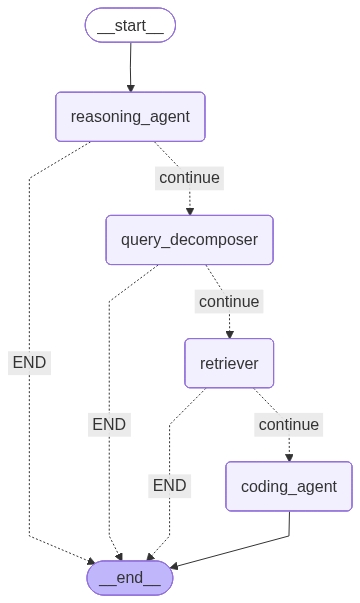

In [8]:
from IPython.display import Image, display

# define nodes and edges
workflow = StateGraph(State)

workflow.add_node("reasoning_agent", reasoning_agent)
workflow.add_node("query_decomposer", query_decomposer)
workflow.add_node("retriever", retriever)
workflow.add_node("coding_agent", coding_agent)

workflow.add_edge(START, "reasoning_agent")
workflow.add_conditional_edges(
    "reasoning_agent",
    route_on_error,
    {
        "END": END,
        "continue": "query_decomposer"
    }
)
workflow.add_conditional_edges(
    "query_decomposer",
    route_on_error,
    {
        "END": END,
        "continue": "retriever"
    }
)
workflow.add_conditional_edges(
    "retriever",
    route_on_error,
    {
        "END": END,
        "continue": "coding_agent"
    }
)
workflow.add_edge("coding_agent", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
state = graph.invoke({
    "query": "Create a scene that visually approximates the value of Pi (π) by \
calculating the area of a unit circle (A=πr2, with r=1, so A=π) using \
the Monte Carlo method"
})

### Old idea (Deprecated)

In [5]:
llm = init_chat_model("groq:openai/gpt-oss-20b", temperature=0.7)

system_prompt = """You are an expert senior Python developer \
specializing in the Manim animation library.  
Your task is to plan out the detailed, step-by-step process \
required to implement a scene in Manim based on the description provided.

Requirements:
1. Break down the scene into clear, actionable, and mutually exclusive \
steps for implementation. Remember mutual exclusiveness is IMPORTANT.
2. Include what objects, animations, and transitions will be used.
3. Mention any special camera movements or effects if they enhance visual appeal.
4. Describe the order of execution logically, from setup to rendering.
5. Avoid writing actual Manim code — focus only on the planning and structure.
"""

prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", "{scene_description}"),
])

# Worker Input
class WorkerStep(BaseModel):
    step_id: int = Field(default=0, description="Step number for scene creation")
    description: str = Field(default="", description="Description of the step")

class WorkerSteps(BaseModel):
    steps: list[WorkerStep] = Field(default_factory=list,
                                    description="Steps required for scene creation")

class WorkerOutput(BaseModel):
    step_id: int = Field(default=0, description="Step number for scene creation")
    url: str = Field(default="", description="Uploaded URL of the generated video")

class WorkerState(BaseModel):
    step_id: int = Field(default=0, description="Step number for scene creation")
    description: str = Field(default="", description="Description of the step")
    docs: str = Field(default="", description="Most relevant documentation of manim \
to assist in writing python code using manim-ce library for the given description")
    feedback: str = Field(default="", description="Feedback to improve the python code")
    code: str = Field(default="", description="Generated python code using manim-ce \
library for the given description")
    code_retry_or_not: str = Field(default="", description="Whether to retry code \
generation or not")
    url: str = Field(default="", description="Uploaded URL of the generated video")
    completed_steps: Annotated[list[WorkerOutput], operator.add] = Field(
        default_factory=list,
        description="List of completed steps with their outputs",
    )  # Workers write to this in parallel, list of WorkerOutput

class State(BaseModel):
    uuid: str = Field(default=uuid4().hex, description="Unique identifier for client")
    prompt: str = Field(default="", description="User prompt for scene generation")
    steps: list[WorkerStep] = Field(default_factory=list,
                                    description="List of planned steps for the scene")
    completed_steps: Annotated[list[WorkerOutput], operator.add] = Field(
        default_factory=list,
        description="List of completed steps with their outputs",
    )  # Workers write to this in parallel, list of WorkerOutput
    success: bool = Field(default=True,
                          description="Indicates if the pipeline completed successfully")
    error_message: str = Field(default="",
                               description="Error message if the pipeline failed")
    sorted_urls: list[str] = Field(default_factory=list,
                                   description="List of video URLs sorted by step_id")

def orchestrator(state: State):
    planner = llm.with_structured_output(WorkerSteps)
    pipeline = prompt_template | planner
    worker_steps = pipeline.invoke({
        "scene_description": state.prompt
    })
    return {
        "steps": worker_steps.steps
    }

def sample_worker(state: WorkerState): 
    step_id = state["step_id"]
    description = state["description"]
    print(f"Processing Step {step_id}: {description}")
    # TODO: Implement actual video generation logic here
    # sample output
    op = WorkerOutput(step_id=step_id,
                      url=f"https://example.com/video_step_{step_id}.mp4")
    return {
        "completed_steps": [op]
    }

def synthesizer(state: State):
    # Sort URLs based on step_id
    sorted_steps = sorted(state.completed_steps, key=lambda x: x.step_id)
    sorted_urls = [step.url for step in sorted_steps]
    return {
        "sorted_urls": sorted_urls
    }

def assign_workers(state: State):
    return [Send("sample_worker", {"step_id": step.step_id, "description": step.description}) for step in state.steps]

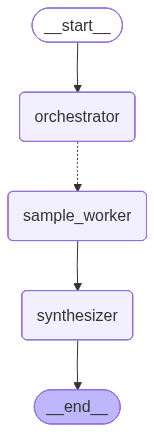

In [6]:
from IPython.display import Image, display

# define nodes and edges
workflow = StateGraph(State)

workflow.add_node("orchestrator", orchestrator)
workflow.add_node("sample_worker", sample_worker)
workflow.add_node("synthesizer", synthesizer)

workflow.add_edge(START, "orchestrator")
workflow.add_conditional_edges(
    "orchestrator", assign_workers, ["sample_worker"]
)
workflow.add_edge("sample_worker", "synthesizer")
workflow.add_edge("synthesizer", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
state = graph.invoke({
    "prompt": "Create a scene that visually approximates the value of Pi (π) by \
calculating the area of a unit circle (A=πr2, with r=1, so A=π) using \
the Monte Carlo method"
})
print(state["sorted_urls"])

Processing Step 1: Create a square of side length 2 centered at the origin to represent the bounding box of the unit circle.
Processing Step 2: Create a unit circle centered at the origin inside the square.
Processing Step 3: Define a parameter for the total number of random points (e.g., 500 or 1000).
Processing Step 4: Generate a list of random (x, y) coordinates uniformly distributed within the square.
Processing Step 5: For each point, create a Dot object: color it green if it lies inside the unit circle, otherwise color it red.
Processing Step 6: Animate the points appearing one by one (or in small batches) to illustrate the Monte Carlo sampling process.
Processing Step 7: After all points have been plotted, compute the ratio of green dots to total points and multiply by 4 to estimate π.
Processing Step 9: Optionally, add a small graph or list that updates the π estimate after each batch of points to show convergence.
Processing Step 8: Create a MathTex or Text object to display t